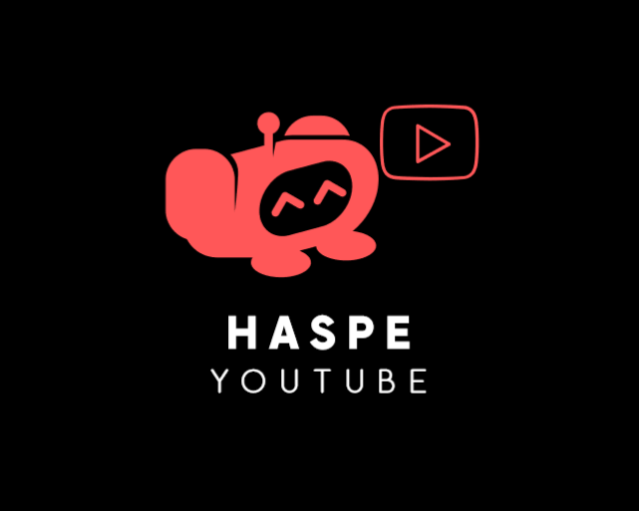

# **Installing and Importing Libraries**

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install transformers
!pip install pytchat
!pip install joblib
!pip install python-telegram-bot
!pip install nest_asyncio

In [2]:
# Import necessary libraries

import nest_asyncio
nest_asyncio.apply()

from typing import Final
import telegram
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertConfig
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from google.colab import files
import pytchat
from pytchat.exceptions import InvalidVideoIdException
import time
import torch
import joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Saved Model and Definining Functions**

In [4]:
# Define constants
TOKEN: Final = 'Telegram Bot API Token'
BOT_USERNAME: Final = 'Telegram Bot Username'

# Load the BERT model and tokenizer
model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

# Load the TensorFlow model
tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'

# Load the label encoder
label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
loaded_label_encoder = joblib.load(label_encoder_filename)

# Device specification
torch_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Hate Speech Detection Project/Project Execution/Backend Development/Hate Speech Detection Models/Mark 12/Saved Model/Hate Speech Hinglish Language/hate_speech_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [5]:
def load_model_and_predict(text):
    # Load the BERT model, tokenizer, and label encoder
    model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
    loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
    loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

    # Load the TensorFlow model
    tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'
    loaded_model.load_weights(tf_model_filename)

    # Load the label encoder
    label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
    loaded_label_encoder = joblib.load(label_encoder_filename)

    # Tokenize and preprocess the input text
    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    # Map the predicted label to "Hate" or "Non-Hate"
    if predicted_label == 'yes':
        return "Hate"
    else:
        return "Non-Hate"

def get_live_comments_with_timeout(video_id, timeout_seconds=4):
    try:
        chat = pytchat.create(video_id=video_id)
    except InvalidVideoIdException:
        return None, "The given YouTube video ID is invalid."

    live_comments = []
    start_time = time.time()

    while chat.is_alive():
        for c in chat.get().sync_items():
            live_comments.append([c.datetime, c.author.name, c.message])

        # Check timeout
        elapsed_time = time.time() - start_time
        if elapsed_time >= timeout_seconds:
            break

    return pd.DataFrame(live_comments, columns=['datetime', 'author', 'message']), None

def classify_live_comments(comments_df):
    classified_live_comments = []

    for live_comment_text in comments_df['message']:
        predicted_label = load_model_and_predict(live_comment_text)
        classified_live_comments.append((live_comment_text, predicted_label))

    return pd.DataFrame(classified_live_comments, columns=['live_comment_text', 'hate_speech_label'])

# **Code for Bot 6 - Haspe Youtube**

In [6]:
# Flag to control whether to continue fetching and classifying live comments
continue_processing = True

async def handle_youtube_live(update: Update, context: ContextTypes.DEFAULT_TYPE):
    global continue_processing

    # Check if the message is in text format
    if not update.message.text:
        await update.message.reply_text("The given input is not in text format. Please enter YouTube Video ID in the text format as Input.")
        return

    # Extract the YouTube video ID from the user's message
    video_id = update.message.text.strip()

    # Check if the video ID has the correct format (11 characters alphanumeric)
    if len(video_id) != 11 or not video_id.isalnum():
        await update.message.reply_text("The given input is not the YouTube Video ID. Please enter YouTube Video ID as Input.")
        return

    # Inform the user that the video ID is being processed
    await update.message.reply_text("Processing your YouTube Live Stream Video. Please wait...")

    # Get live comments for the specified YouTube video within the initial 4-second duration
    live_comments_df, error_message = get_live_comments_with_timeout(video_id, timeout_seconds=4)

    if error_message:
        await update.message.reply_text(error_message)
        return

    # Classify live comments for hate speech
    classified_live_comments = classify_live_comments(live_comments_df)

    # Accumulate the messages into a single string
    response_message = ""
    for index, row in classified_live_comments.iterrows():
        response_message += f"YouTube Comment {index + 1}: {row['live_comment_text']}\nHate Speech Prediction for Comment: {row['hate_speech_label']}\n\n"

    # Check if response_message is empty
    if not response_message:
        response_message = "No comments detected or classified."

    # Send the accumulated message as a single message to the user
    await update.message.reply_text(response_message)

    # Stop further processing after the initial 4 seconds
    continue_processing = False

async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Hello! Thanks for chatting with me! I am the Haspe Youtube Bot.')

async def help1_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('I am the Haspe Youtube Bot! Please send me the Video ID of the youtube live stream video in a plain text format so I can process its live comments for hate speech.')

async def help2_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('If you dont get any output even after waiting for more than 2 minute then please submit the Youtube Live Stream Video ID again in the text format.')

async def help3_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('The Fetching and Prediction process of the Youtube Live Stream Comments has been stopped as per the preset timer of 4 seconds. If you want to fetch and predict more comments then you can send the Video ID again in a plain text format.')

async def youtube_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Please send me Video ID of Youtube Live Stream in a plain text format!')

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    # Check if the message is in text format
    if not update.message.text:
        await update.message.reply_text("The given input is not in text format. Please enter YouTube Video ID in the text format as Input.")
        return

    # Extract the YouTube video ID from the user's message
    video_id = update.message.text.strip()

    # Check if the video ID has the correct format (11 characters alphanumeric)
    if len(video_id) != 11 or not video_id.isalnum():
        await update.message.reply_text("The given input is not the YouTube Video ID. Please enter YouTube Video ID as Input.")
        return

    # Get live comments for the specified YouTube video
    live_comments_df, error_message = get_live_comments_with_timeout(video_id, timeout_seconds=4)

    if error_message:
        await update.message.reply_text(error_message)
        return

    # Classify live comments for hate speech
    classified_live_comments = classify_live_comments(live_comments_df)

    # Accumulate the messages into a single string
    response_message = ""
    for index, row in classified_live_comments.iterrows():
        response_message += f"YouTube Comment {index + 1}: {row['live_comment_text']}\nHate Speech Prediction for Comment: {row['hate_speech_label']}\n\n"

    # Check if response_message is empty
    if not response_message:
        response_message = "No comments detected or classified. Please enter the same YouTube Video ID again or enter a different YouTube Video ID."

    # Send the accumulated message as a single message to the user
    await update.message.reply_text(response_message)


In [ ]:
# Set up the Telegram bot
if __name__ == '__main__':
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler('start', start_command))
    app.add_handler(CommandHandler('help1', help1_command))
    app.add_handler(CommandHandler('help2', help2_command))
    app.add_handler(CommandHandler('help3', help3_command))
    app.add_handler(CommandHandler('youtube', youtube_command))

    # Handle YouTube live stream command
    app.add_handler(MessageHandler(None, handle_youtube_live))

    # Run the bot
    print("Polling...")
    app.run_polling()

    # Poll for more comments in subsequent 4-second durations until user stops or requests again
    while True:
        # Break the loop if processing is stopped
        if not continue_processing:
            break

        # Get live comments for the specified YouTube video within the subsequent 4-second duration
        live_comments_df = get_live_comments_with_timeout(video_id, timeout_seconds=4)

        # Classify live comments for hate speech
        classified_live_comments = classify_live_comments(live_comments_df)

        # Accumulate the messages into a single string
        response_message = ""
        for index, row in classified_live_comments.iterrows():
            response_message += f"Youtube Live Stream Comment {index + 1}:\n{row['live_comment_text']}\nHate Speech Prediction: {row['hate_speech_label']}\n\n"

        # Send the accumulated message as a single message to the user
        await update.message.reply_text(response_message)

Polling...
